Viscoelastoplasticity in simple shear
======

**Implementation order**


In this notebook, we use a different order to `vep_original'

1) first we ignore elasticity and define a yield viscosity:

$$ \eta_{p} = \frac{\tau_y}{2\dot \epsilon_{II}}$$


2) The viscosity defining the visco-plastic part of problem is given by:

$$\eta_{vp} = min(\eta, \eta_{p})$$


where $\eta$ is the background viscosity (constant here)


3) We then use $\eta_{vp}$ to define a visco-elastic-plastic visosity accoridng to 

$$ \eta_{vep} = ( \eta_{vp} \Delta t) / (\alpha + \Delta t)$$

$\eta_{vep}$ is the value that is provided to the Stokes system



**Simple shear in two dimensions**

This notebook models a viscoelastoplastic material, with a maximum yield strength of $\tau_y = 2.0$, undergoing simple shear in two dimensions. The vertical velocity boundary conditions are periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = 1$.  For $t > 1$ the top wall velocity is taken to zero with the stored elastic stress allowed to relax.

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
uw.matplotlib_inline()

import matplotlib.pyplot as pyplot
pyplot.ion()  # don't hang on show() for pure python runs
import numpy as np
import math

import mpi4py
comm = mpi4py.MPI.COMM_WORLD
import os

In [2]:
# Paramters

#Model setup
#elementType = "Q2/dPc1"
elementType ="Q1/dQ0"
Res = 64



# Define material parameters

# define background material properties
eta_bg     = 1.0e-2
density_bg = 0.0

# define beam material properties
density = 1.
eta     = 1.0e2                            # viscosity
mu      = 1.0e2                           # elastic modulus
yieldStress = 1.0


#Elasticity and timestepping
#alpha   = eta / mu                         # viscoelastic relaxation time
dt_e    = 0.1                              # elastic time step
num_step_factor = 0.1

dt_num = dt_e*num_step_factor              # max numerical timestep


#Tolerance and stability
#min_viscosity = 0.001
ksp_rtol = 1e-06                           #Relative decrease in residual norm
nl_tolerance = 1e-4                        #Non-linear tolerance


nsteps = 10
nsteps_relax = 0

In [3]:
#alpha

In [4]:
# create output directory
try:
    workdir
except NameError:
    workdir = os.path.abspath(".")

outputPath = os.path.join(workdir,"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

In [5]:
#Create mesh and finite element variables


mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (Res, Res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.),
                                 periodic    = [False, False]  ) 

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [6]:
# Apply velocity boundary conditions
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
leftWall = mesh.specialSets["MinI_VertexSet"]

# no slip on left wall, free slip on all others
cantileverBC = uw.conditions.DirichletCondition( variable       = velocityField, 
                                            indexSetsPerDof = ( iWalls, jWalls + leftWall) ) 

In [7]:
# create swarm
swarm         = uw.swarm.Swarm( mesh=mesh,  particleEscape=True)
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# add swarm variable
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

# add previous stress swarm variable to carry the stress history term
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]

# create tracer particle within beam
tracerSwarm = uw.swarm.Swarm( mesh=mesh )
tracerSwarm.add_particles_with_coordinates(np.array([(0.45,0.5)]))

/opt/underworld2/underworld/swarm/layouts.py:150: UserWarning: Note that the 'GlobalSpaceFillerLayout' will be deprecated in future releases of Underworld. The `PerCellSpaceFillerLayout` provides similar functionality.
  warnings.warn("Note that the 'GlobalSpaceFillerLayout' will be deprecated in future releases of Underworld. "


array([0], dtype=int32)

In [8]:
#uw.swarm.Swarm?

In [9]:
# layout materials
background  = 0
beam        = 1

coord = fn.input()
conditions = [ (  (coord[1] >= 0.44) 
                & (coord[1] <= 0.56) 
                & (coord[0] <= 0.5), beam),
               (             True , background ),
             ]

materialIndex.data[:]  = fn.branching.conditional( conditions ).evaluate(swarm)


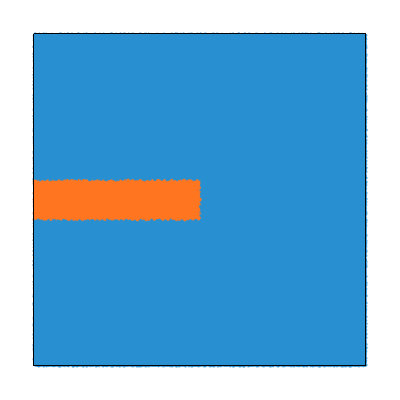

In [10]:
figsize=(400,400) 
figMaterial = glucifer.Figure( figsize=figsize )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=4.0, colourBar=False) )
figMaterial.append( glucifer.objects.VectorArrows(mesh, velocityField) )
figMaterial.append( glucifer.objects.Points(tracerSwarm, pointSize=15.0) )

figMaterial.show()

In [11]:
# define strain rate tensor

strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

In [12]:
# map viscosity to material
mappingDictViscosity = { background : eta_bg, 
                               beam : eta }

viscosityMapFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictViscosity )

# define the viscoelastic stress tensor

vpStressFn = 2. * viscosityMapFn * strainRate_2ndInvariant

In [13]:

# yield stress
yieldStressFn = fn.misc.constant(yieldStress)

In [14]:

# define viscosity at yield stress
yieldingViscosityFn = 0.5*yieldStressFn / ( strainRate_2ndInvariant + 1.0e-18 )  

# define visco-plastic viscosity function
#visco_plasticFn = fn.misc.min(yieldingViscosityFn, viscosityMapFn)

visco_plastic_conds = [ (  vpStressFn > yieldStressFn, yieldingViscosityFn),
               (             True , viscosityMapFn ),
             ]

visco_plasticFn  = fn.branching.conditional( visco_plastic_conds)


#
#alphaFn = viscosityMapFn/mu
alphaFn = visco_plasticFn/mu


# viscoelastic effective viscosity
eta_eff = ( visco_plasticFn * dt_e ) / (alphaFn + dt_e)  # effective viscosity





# define the final viscosity function


viscosityFn = fn.exception.SafeMaths(eta_eff)


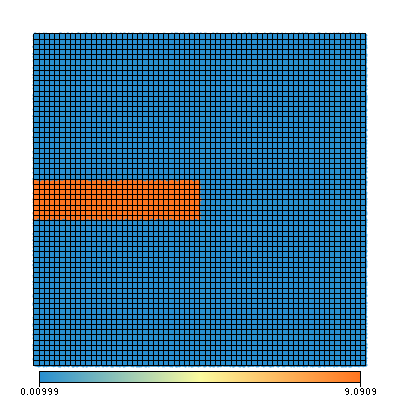

In [15]:
# plot viscosity 
figViscosity = glucifer.Figure( figsize=figsize )
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=4.0) )
figViscosity.append( glucifer.objects.Mesh(mesh))

figViscosity.show()

In [16]:
# define the viscoelastic stress tensor

viscousStressFn = 2. * viscosityFn * strainRate 

elasticStressFn = viscosityFn / ( mu * dt_e ) * previousStress
stressFn        = viscousStressFn + elasticStressFn


viscousStress_2nInvariant = fn.math.sqrt(0.5*(viscousStressFn[0]**2+viscousStressFn[1]**2)+viscousStressFn[2]**2)
elasticStress_2nInvariant = fn.math.sqrt(0.5*(elasticStressFn[0]**2+elasticStressFn[1]**2)+elasticStressFn[2]**2)
stress_2ndInvariant = fn.math.sqrt(0.5*(stressFn[0]**2+stressFn[1]**2)+stressFn[2]**2)



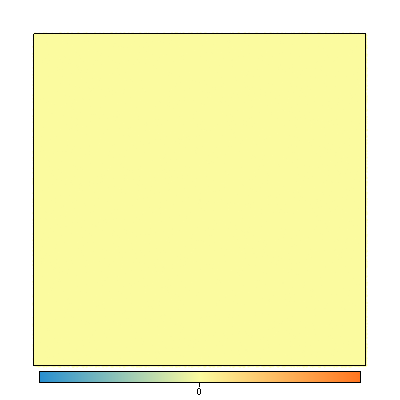

In [17]:
# plot xx-comp stress

figStressXX = glucifer.Figure( figsize=figsize )
figStressXX.append( glucifer.objects.Points(swarm, stressFn[0], pointSize=4.0) )
figStressXX.show()

In [18]:
# functions for calculating RMS velocity
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )


In [19]:
# density
mappingDictDensity = { background : density_bg,
                             beam : density }
densityFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictDensity )

# buoyancy force term
gravity = 1.
z_hat   = ( 0.0, 1.0 )
buoyancyFn = -densityFn * gravity * z_hat

In [20]:
# create stokes system, solver and advector
stokes = uw.systems.Stokes( velocityField       = velocityField, 
                               pressureField    = pressureField,
                               voronoi_swarm     = swarm, 
                               conditions       = [cantileverBC,],
                               fn_viscosity     = viscosityFn, 
                               fn_bodyforce     = buoyancyFn,
                               fn_stresshistory = elasticStressFn)

solver   = uw.systems.Solver( stokes )

solver.options.scr.ksp_rtol = ksp_rtol

advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
tracerAdvector = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )

In [21]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    #dt = advector.get_max_dt()
    # cap time step for observation time 
    #if dt > dt_num:
    dt = dt_num   # fix this

    # Advect using this timestep size.
    advector.integrate(dt)
    tracerAdvector.integrate(dt)
        
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressFn_data = stressFn.evaluate(swarm)
    previousStress.data[:] = ( phi*stressFn_data[:] + ( 1.-phi )*previousStress.data[:] )
    
    return time+dt, step+1

In [22]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

deflection = tracerSwarm.particleCoordinates.data[0][1]


# save stress history for plotting
tTracer           = []
srTracer          = []   
vyTracer          = []
totalStress_xy    = [] 

point_eval = (0.5, 0.5)

In [23]:
# load beam until y = 0.4
while step < nsteps:
    # output for analysis               
    tTracer.append(time)
    # keep record of ...


    # solve stokes problem
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tolerance)
    
    #
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    # print model infi
    if( comm.rank ==0):
        if step%10 == 0:
            print time, step, deflection, stress_2ndInvariant.evaluate(swarm).max()\
            
    vyTracer.append(velocityField.evaluate(tracerSwarm)[0][0])
    srTracer.append(strainRate_2ndInvariant.evaluate(tracerSwarm)[0][0])
    totalStress_xy.append(stressFn[2].evaluate(swarm)[0])
    
    # We are finished with current timestep, update.
    time, step = update()
    
    
    


0.0 0 0.5 0.839900508942


In [24]:
previousStress.evaluate(swarm)[:,0].max(), pressureField.evaluate(swarm)[:].min()

(0.64742955231387245, -1.3998648793937023)

In [26]:
viscosityFn.evaluate(swarm).min()

0.00999000999000999


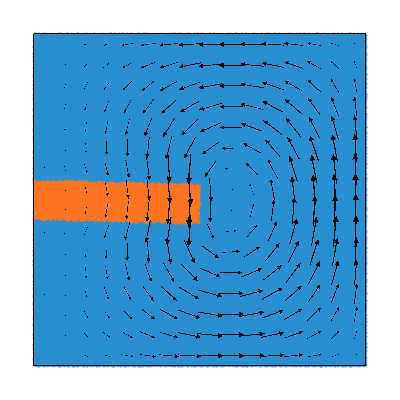

In [27]:
figMaterial.show()


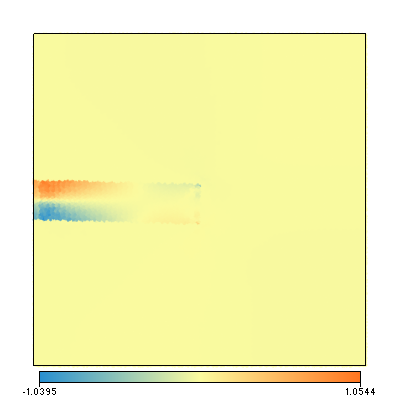

In [28]:
# plot stress
figStressXX.show()


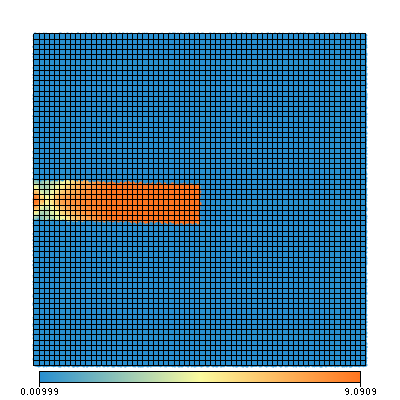

In [29]:
figViscosity.show()

In [30]:
step

10

In [31]:
import matplotlib.pyplot as plt

In [32]:
#vyTracer, tTracer

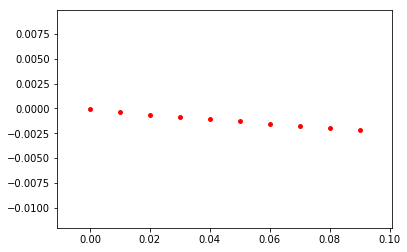

In [33]:
fig, ax = plt.subplots()

ax.scatter(tTracer, np.array(vyTracer), s = 15, c = 'r')
#ax.scatter(tTracer, totalStress_xy, s = 15, c = 'k')

#ax.set_xlim(-0.1, 2.1)

#ax.set_ylim(-0.1, 0.2)

In [32]:
vyTracer[0]

-0.00015263855684371016

In [91]:
# re-build stokes - turn off buoyancy
stokesNew = uw.systems.Stokes( velocityField    = velocityField, 
                           pressureField     = pressureField,
                           #voronoi_swarm     = swarm, 
                           conditions        = [cantileverBC,],
                           fn_viscosity      = viscosityMapFn, 
                           fn_bodyforce      = None,
                           fn_stresshistory = elasticStressFn)

solverNew = uw.systems.Solver( stokesNew )

In [92]:
# allow elastic stresses to relax for 10 steps
nsteps = step+nsteps_relax

while step < nsteps:
    
    tTracer.append(time)
    # solve stokes problem
    solverNew.solve()          
    # update.
    time, step = update()
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    if step%10 == 0:            
        print step, time, deflection
        
        
    vyTracer.append(velocityField.evaluate(tracerSwarm)[0][0])
    srTracer.append(strainRate_2ndInvariant.evaluate(tracerSwarm)[0][0])
    totalStress_xy.append(stressFn[2].evaluate(swarm)[0])

20 0.2 0.484227632865



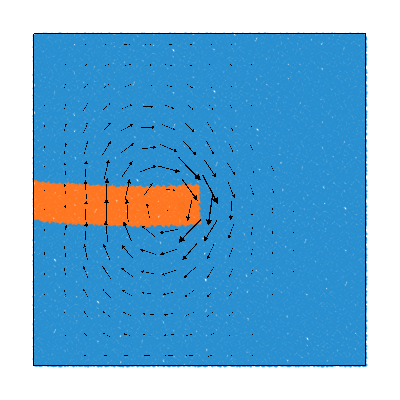

In [97]:
figMaterial.show()


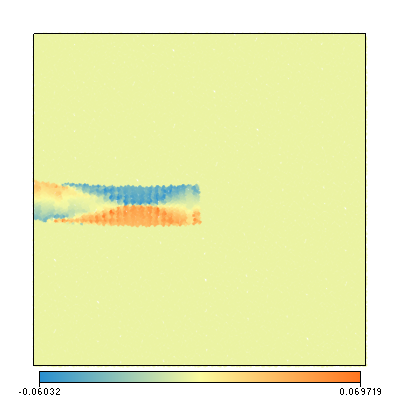

In [94]:
figStressXX.show()

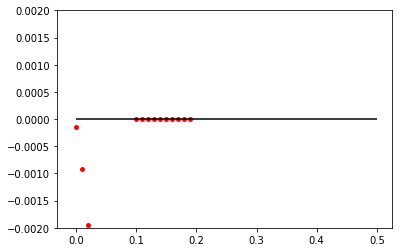

In [95]:
fig, ax = plt.subplots()

ax.scatter(tTracer, np.array(vyTracer), s = 15, c = 'r')


ax.set_ylim(-0.002, 0.002)
#ax.set_xlim(0.0, 0.5)

ax.hlines(0, 0, 0.5)

In [34]:
#np.savetxt('saved_data/alt_yielding.csv', 
#          np.column_stack((tTracer,vyTracer)))

In [ ]:
#dt